In [ ]:
"""
https://www.scrapingbee.com/blog/web-scraping-booking/
https://selenium-python.readthedocs.io/locating-elements.html
https://stackoverflow.com/questions/72165030/selenium-script-searches-previous-tabs-html-after-opening-a-new-tab
https://stackoverflow.com/questions/66956197/vs-code-modulenotfounderror-no-module-named-sklearn
"""

In [49]:
pip install selenium selenium-wire webdriver-manager pandas scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.1 -> 23.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import numpy as np
import selenium
import time
from selenium.webdriver.common.by import By
from seleniumwire import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import sklearn
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# **Crawling**

To use selenium with google chrome we need to create a driver with the wanted url. This function will create and return a driver object.

In [3]:
def create_driver(url):
    driver = webdriver.Chrome()
    driver.get(url)
    #print(driver.title)
    return driver

The following function takes the driver and goes through the result pages to extract the hotel names and links to their pages.
It returns a dataframe of the results.

In [6]:
def get_hotel_links(city_driver):
    names = []
    links_for_hotel_pages = []
    distance_from_center = []
    
    number_of_pages = int(city_driver.find_element(By.CSS_SELECTOR, 'div[data-testid="pagination"]  li:last-child').text)

    for page in range(1, number_of_pages+1):
        # delete former requests
        del city_driver.requests
        # get hotel cards from search results
        hotels_from_search = city_driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="property-card"]')
        # get info from each hotel card
        for hotel_card in hotels_from_search:
            names.append(hotel_card.find_element(By.CSS_SELECTOR, 'div[data-testid="title"]').text)
            links_for_hotel_pages.append(hotel_card.find_element(By.CSS_SELECTOR, 'a[data-testid="title-link"]').get_attribute('href'))
            distance_from_center.append(hotel_card.find_element(By.CSS_SELECTOR, 'span[data-testid="distance"]').text)
        # in the last page we dont need to click on next page button
        if page == number_of_pages:
            break
        # click on next page button
        next_page_btn = city_driver.find_element(By.XPATH, '//button[contains(@aria-label, "Next page")]')
        next_page_btn.click()
        # wait for the next page to load before acquiring more data or till timeout in 20 seconds
        city_driver.wait_for_request("/dml/graphql", timeout=20)
        time.sleep(5)

    hotels_info = {"hotel_names": names, "links": links_for_hotel_pages, 'distance_from_center': distance_from_center}
    city_df = pd.DataFrame(hotels_info)
    print("finished loading data")
    return city_df

This function goes through the list of cities, creates a driver and calls the function that will extract the hotel links from the browser. Then it closes the connection and saves the data into a file.

In [7]:
def get_hotel_links_from_cities():
    cities_and_urls = {"paris": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Paris&ssne=Paris&ssne_untouched=Paris&efdco=1&lang=en-gb&src=searchresults&dest_id=-1456928&dest_type=city&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "nice": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Nice%2C+Provence-Alpes-C%C3%B4te+d%27Azur%2C+France&ssne=Paris&ssne_untouched=Paris&lang=en-gb&src=searchresults&dest_id=-1454990&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=5eb2597cf50b0023&ac_meta=GhA1ZWIyNTk3Y2Y1MGIwMDIzIAAoATICZW46BG5pY2VAAEoAUAA%3D&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "marseille": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Marseille%2C+Provence-Alpes-C%C3%B4te+d%27Azur%2C+France&ssne=Nice&ssne_untouched=Nice&lang=en-gb&src=searchresults&dest_id=-1449947&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=00145996f939055a&ac_meta=GhAwMDE0NTk5NmY5MzkwNTVhIAAoATICZW46CW1hcnNlaWxsZUAASgBQAA%3D%3D&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204",
              "lyon": "https://www.booking.com/searchresults.en-gb.html?label=Catch_All-EN-131006968001-bPiN0WYm7x7ddzlXSroMLwS548793046706%3Apl%3Ata%3Ap1%3Ap2%3Aac%3Aap%3Aneg%3Afi%3Atiaud-294889297093%3Adsa-1642216383571%3Alp1008002%3Ali%3Adec%3Adm&sid=176ab549c47fbf99c9ee1b8552278873&aid=318615&ss=Lyon%2C+Rh%C3%B4ne-Alps%2C+France&ssne=Marseille&ssne_untouched=Marseille&lang=en-gb&src=searchresults&dest_id=-1448468&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=1&search_selected=true&search_pageview_id=6d9459a8df7400df&ac_meta=GhA2ZDk0NTlhOGRmNzQwMGRmIAAoATICZW46CNea15jXndeeQABKAFAA&checkin=2023-04-10&checkout=2023-04-13&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure&nflt=ht_id%3D204"}
    for city in cities_and_urls.keys():
        city_driver = create_driver(cities_and_urls[city])
        city_links_df = get_hotel_links(city_driver)
        # close the driver for this hotel 
        city_driver.close()
        city_driver.quit()
        # save the information in a csv file
        file_name = "./data/" + city + "_hotel_links"
        city_links_df.to_csv(file_name, index=False)
        time.sleep(5)

Run the function that gets the hotel links from the wanted cities and saves then to csv file.

In [8]:
get_hotel_links_from_cities()

finished loading data
finished loading data
finished loading data
finished loading data


In [1]:
def get_parameters_from_hotels(df_links):
    list_of_parameters = {"Air conditioning": [], "Heating": [], "WiFi is available in all areas and is free of charge.": [],
                         "City view": [], "Wardrobe or closet": [], "Soundproofing": [], "TV": [], "Coffee machine": [],
                          "Private bathroom": [], "Lift": [], "Safety deposit box": [], "Pets are allowed. Charges may be applicable.": [],
                         "24-hour front desk": [], "Bar": [], "Room service": [], "Fitness centre": [], "Spa lounge/relaxation area": [],
                         "Electric kettle": [], "Minibar": [], "Tea/Coffee maker": [], "Restaurant": [], "Parking garage": [],
                          "Airport shuttle": [], "Non-smoking rooms": [], "24-hour security": [], "Towels": [],
                          "Facilities for disabled guests": [],"Hairdryer": [], "Iron": [], "Electric vehicle charging station": []}
    names = []
    stars = []
    distance = []
    pool = []
    breakfast = []
    breakfast_and_dinner = []
    addresses = []
    free_cancellations = []
    
    for ind in df_links.index:
        print("hotel number: " ,int(ind))
        # get link from df
        link = df_links.iloc[ind]['links']
        
        # create the driver for this hotel
        hotel_driver = create_driver(link)
        time.sleep(5) 
        
        try:
            # enter the main page where the first hotel is the one we want, click the first hotel name
            #hotel_page_btn = hotel_driver.find_element(By.CSS_SELECTOR, 'a[class="fc63351294 a822bdf511 d4b6b7a9e7 fa565176a8 f7db01295e f4605622ad b2f0d6a80e"]')
            hotel_page_btn = hotel_driver.find_element(By.CSS_SELECTOR, 'a[class="e13098a59f"]')
            hotel_page_btn.click()
            # wait for the hotel page to load before acquiring more data or till timeout in 20 seconds
            hotel_driver.wait_for_request("/fragment.en-gb.json", timeout=30)
            # window_after is the tab with the hotel
            window_after = hotel_driver.window_handles[1]
            # switches the current window to the new tab
            hotel_driver.switch_to.window(window_after)
            time.sleep(1)
        except Exception as e: 
            pass
            
        # add hotel name to list
        names.append(df_links['hotel_names'][ind]) 
        # get number of stars and add to list
        number_of_stars = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[data-testid="rating-stars"]  span[class="b6dc9a9e69 adc357e4f1 fe621d6382"]'))
        stars.append(number_of_stars)
        # get distance from city center from df
        distance.append(df_links['distance_from_center'][ind])
        
        print("The current time is: ", time.ctime())
        time.sleep(15)
        print("The current time is: ", time.ctime())
        
        # from this point on we are getting parameters from the page
        # find if there are meals
        is_breakfast_and_dinner = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="bui-text--color-constructive"]'))
        breakfast_and_dinner.append(1 if is_breakfast_and_dinner > 0 else 0)
        is_breakfast = len(hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="ungreen-condition-green"]'))
        breakfast.append(1 if is_breakfast > 0 else 0)
        # find if there is a pool
        titles = hotel_driver.find_elements(By.CSS_SELECTOR, 'div[class="db29ecfbe2 f0d4d6a2f5"] span[class="db312485ba"')
        is_there_pool = 0
        for title in titles:
            if title.text == "Indoor swimming pool" or title.text == "Outdoor swimming pool":
                is_there_pool = 1
        pool.append(is_there_pool)
        try:
            # wait for the address element to be present on the page
            wait = WebDriverWait(hotel_driver, 15)
            address_element = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#showMap2 > span.hp_address_subtitle.js-hp_address_subtitle.jq_tooltip")))
            # get address
            addresses.append(address_element.text)
        except:
            # mark the address element was not present on the page
            addresses.append(None)
        # wait for the list, then get facilities from the list
        wait = WebDriverWait(hotel_driver, 40)
        facilities_list = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'span[class="db312485ba"')))

        # make facilities list into text
        text_facilities_list = []
        for f in facilities_list:
            text_facilities_list.append(f.text)
        # check if facilities exists
        print(df_links['hotel_names'][ind], "has" ,len(text_facilities_list), "facilities")
        # add policies- there are 2 possible classes for them in the list
        wait = WebDriverWait(hotel_driver, 25)
        try:
            policy_services = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'div[class="db29ecfbe2 c90c0a70d3 a34d1a4138"]')))
        except:
            try:
                policy_services = wait.until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, 'div[class="bui-spacer--medium hotel-facilities-group__policy"]')))
            except:
                print(df_links['hotel_names'][ind], "has empty policies list")

        # add the policies to the list of facilities
        for p in policy_services:
            text_facilities_list.append(p.text)
        
        # add 1 if the parameter exists
        for parameter in list_of_parameters.keys():
            if parameter in text_facilities_list:
                list_of_parameters[parameter].append(1)
            else:
                list_of_parameters[parameter].append(0)
        
        # check if there is free cancellation
        cancellations_list = hotel_driver.find_elements(By.CSS_SELECTOR, 'span[class="hprt-item--emphasised"]')
        is_there_free_cancellation = 0
        for f in cancellations_list:
            if f.text == "Free cancellation":
                is_there_free_cancellation = 1
        free_cancellations.append(is_there_free_cancellation)
        
        time.sleep(3)  
        # close the driver for this hotel 
        hotel_driver.close()
        hotel_driver.quit()
        
    # the data we got from other parts of the page(not the facilities list)
    full_data_city = {'hotel_names': names, 'star_rating': stars, 'distance_from_center': distance,
                      'swimmingpool': pool, 'breakfast': breakfast, 'breakfast_and_dinner': breakfast_and_dinner,
                      'free_cancellation': free_cancellations, 'address': addresses}
    # merge the dictioneries 
    full_data_city.update(list_of_parameters)
    return pd.DataFrame(full_data_city)

Get the links for the hotels in the city from the csv file we saved earlier.

In [4]:
# returns dataframe with hotel names, links and distance from center
def get_links_from_file(city):
    file_name = "./data/" + city + "_hotel_links"
    df_city_links = pd.read_csv(file_name)
    return df_city_links

Go through the list of hotels and extract the wanted parameters from each hotel's page.

In [5]:
def get_parameters_for_city(city):
    df_city_links = get_links_from_file(city)
    # get dataframe with all the parameters of the hotels
    df_parameters = get_parameters_from_hotels(df_city_links)
    # save the information in a csv file
    file_name = "./data/" + city + "_hotels_parameters"
    df_parameters.to_csv(file_name, index=False)
    time.sleep(40)
    print("finished saving parameters for {} hotels".format(city))
    print(df_parameters)
    print("----------------")
        

In [28]:
def get_parameters_from_file(city):
    file_name = "./data/" + city + "_hotels_parameters"
    df_city_parameters = pd.read_csv(file_name)
    return df_city_parameters

Run to get the parameters from Nice.

In [6]:
get_parameters_for_city("nice")

hotel number:  0
The current time is:  Thu Feb  2 19:27:51 2023
The current time is:  Thu Feb  2 19:28:06 2023
Share Inn has 58 facilities
hotel number:  1
The current time is:  Thu Feb  2 19:29:09 2023
The current time is:  Thu Feb  2 19:29:24 2023
Hôtel Apollinaire Nice has 77 facilities
hotel number:  2
The current time is:  Thu Feb  2 19:30:27 2023
The current time is:  Thu Feb  2 19:30:42 2023
Goldstar Apartments & Suites has 121 facilities
hotel number:  3
The current time is:  Thu Feb  2 19:31:48 2023
The current time is:  Thu Feb  2 19:32:03 2023
Le Meridien Nice has 93 facilities
hotel number:  4
The current time is:  Thu Feb  2 19:33:07 2023
The current time is:  Thu Feb  2 19:33:22 2023
Best Western Plus Hôtel Massena Nice has 77 facilities
hotel number:  5
The current time is:  Thu Feb  2 19:34:24 2023
The current time is:  Thu Feb  2 19:34:39 2023
Hotel Le Negresco has 99 facilities
hotel number:  6
The current time is:  Thu Feb  2 19:35:45 2023
The current time is:  Thu F

In [29]:
df_nice = get_parameters_from_file("nice")
df_nice

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Restaurant,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station
0,Share Inn,0,250 m from centre,0,0,0,1,"21 Rue Massena, 06000 Nice, France",1,1,...,0,0,0,1,1,1,1,1,1,0
1,Hôtel Apollinaire Nice,4,400 m from centre,0,1,0,1,"25 Boulevard Dubouchage, 06000 Nice, France",1,1,...,0,0,0,1,0,0,1,1,0,0
2,Goldstar Apartments & Suites,4,0.7 km from centre,0,1,0,1,"45, Rue Maréchal Joffre, 06000 Nice, France",1,1,...,0,1,1,1,0,1,1,1,1,0
3,Le Meridien Nice,4,400 m from centre,1,1,0,1,"1, promenade des Anglais, 06000 Nice, France",1,0,...,1,0,0,1,1,1,1,1,0,0
4,Best Western Plus Hôtel Massena Nice,4,100 m from centre,0,1,0,1,"58, rue Gioffredo, 06000 Nice, France",1,1,...,0,1,0,1,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Logis Hôtel Villa Victorine,2,4.3 km from centre,0,0,0,1,"11 avenue du Docteur Emile Roux, Arenas, 06200...",1,1,...,0,0,0,1,1,1,0,1,0,1
148,H33 Hôtel,2,300 m from centre,0,0,0,0,"33 Rue Pastorelli, 06000 Nice, France",1,1,...,0,0,0,0,0,1,0,1,0,0
149,Résidence Akantha,0,400 m from centre,0,0,0,0,2 -ème étage porte face a l ascenseur 16 Rue H...,1,1,...,0,0,0,1,0,1,0,1,1,0
150,Hotel Cronstadt,3,1.1 km from centre,0,0,0,0,"3 Rue Cronstadt, 06000 Nice, France",1,1,...,0,1,0,1,1,1,0,1,0,0


Run to get the parameters from Marseille.

In [13]:
get_parameters_for_city("marseille")

hotel number:  0
The current time is:  Thu Feb  2 23:02:52 2023
The current time is:  Thu Feb  2 23:03:07 2023
Maisons du Monde Hôtel & Suites - Marseille Vieux Port has 52 facilities
hotel number:  1
The current time is:  Thu Feb  2 23:04:09 2023
The current time is:  Thu Feb  2 23:04:24 2023
Toyoko INN Marseille Saint Charles has 83 facilities
hotel number:  2
The current time is:  Thu Feb  2 23:05:26 2023
The current time is:  Thu Feb  2 23:05:41 2023
Hôtel Hermès has 62 facilities
hotel number:  3
The current time is:  Thu Feb  2 23:06:43 2023
The current time is:  Thu Feb  2 23:06:58 2023
Hôtel Maison Montgrand - Vieux Port has 79 facilities
hotel number:  4
The current time is:  Thu Feb  2 23:08:00 2023
The current time is:  Thu Feb  2 23:08:15 2023
Maison Juste has 65 facilities
hotel number:  5
The current time is:  Thu Feb  2 23:09:17 2023
The current time is:  Thu Feb  2 23:09:32 2023
Ibis Marseille Centre Prefecture has 40 facilities
hotel number:  6
The current time is:  Th

In [30]:
df_marseille = get_parameters_from_file("marseille")
df_marseille

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Restaurant,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station
0,Maisons du Monde Hôtel & Suites - Marseille Vi...,4,0.5 km from centre,0,1,0,1,"43 Quai des Belges, 13001 Marseille, France",1,1,...,0,0,0,1,0,1,1,1,0,0
1,Toyoko INN Marseille Saint Charles,3,0.7 km from centre,0,0,0,1,"25 Avenue du General Leclerc, 13003 Marseille,...",1,1,...,0,1,0,1,0,1,1,1,1,0
2,Hôtel Hermès,2,0.5 km from centre,0,0,0,1,"2 rue Bonneterie, 13002 Marseille, France",1,1,...,0,1,0,1,0,0,1,1,0,0
3,Hôtel Maison Montgrand - Vieux Port,3,0.8 km from centre,0,1,0,1,"35 Rue Montgrand, 13006 Marseille, France",1,1,...,1,0,0,1,1,1,0,1,1,0
4,Maison Juste,0,0.7 km from centre,0,0,0,1,"28 Rue Balthazar-Dieudé, Castellane et Préfect...",1,1,...,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,HOTEL SYLVABELLE,1,1.1 km from centre,0,0,0,1,"63 Rue Sylvabelle, Castellane et Préfecture, 1...",0,1,...,0,0,0,1,1,1,0,0,0,0
125,Chambre privée avec jacuzzi,0,1 km from centre,0,0,0,1,"8 Boulevard Eugène Pierre, 13005 Marseille, Fr...",1,1,...,0,0,0,1,0,1,0,1,0,0
126,Five Stars S1,0,100 m from centre,0,0,0,0,"20 Cours Belsunce, 13001 Marseille, France",1,1,...,0,0,0,1,0,1,0,0,0,0
127,FIVE STARS S8,0,100 m from centre,0,0,0,0,"20 Cours Belsunce, 13001 Marseille, France",1,0,...,0,0,0,1,0,0,0,0,0,0


Run to get the parameters from Lyon.

In [14]:
get_parameters_for_city("lyon")

hotel number:  0
The current time is:  Fri Feb  3 01:46:32 2023
The current time is:  Fri Feb  3 01:46:47 2023
Villa Florentine has 105 facilities
hotel number:  1
The current time is:  Fri Feb  3 01:47:48 2023
The current time is:  Fri Feb  3 01:48:03 2023
Best Western Hotel du Pont Wilson has 94 facilities
hotel number:  2
The current time is:  Fri Feb  3 01:49:03 2023
The current time is:  Fri Feb  3 01:49:18 2023
Hotel De Verdun 1882, BW Signature Collection has 59 facilities
hotel number:  3
The current time is:  Fri Feb  3 01:50:17 2023
The current time is:  Fri Feb  3 01:50:32 2023
Campanile Lyon Centre - Berges du Rhône has 91 facilities
hotel number:  4
The current time is:  Fri Feb  3 01:51:34 2023
The current time is:  Fri Feb  3 01:51:49 2023
Warwick Reine Astrid - Lyon has 94 facilities
hotel number:  5
The current time is:  Fri Feb  3 01:52:49 2023
The current time is:  Fri Feb  3 01:53:04 2023
La Résidence has 81 facilities
hotel number:  6
The current time is:  Fri Feb 

In [31]:
df_lyon = get_parameters_from_file("lyon")
df_lyon

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Restaurant,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station
0,Villa Florentine,5,0.8 km from centre,1,1,0,1,"25 Montée St Barthélémy, 5th arr., 69005 Lyon,...",1,1,...,1,0,0,1,1,1,1,1,0,1
1,Best Western Hotel du Pont Wilson,4,0.7 km from centre,0,1,0,1,"6, rue Mazenod, 3rd arr., 69003 Lyon, France",1,1,...,0,1,0,1,1,1,1,1,0,0
2,"Hotel De Verdun 1882, BW Signature Collection",3,0.9 km from centre,0,0,0,1,"82 Rue de la Charité, 2nd arr., 69002 Lyon, Fr...",1,1,...,0,0,0,1,1,1,0,1,0,0
3,Campanile Lyon Centre - Berges du Rhône,3,0.8 km from centre,0,1,0,1,"4-6, rue Mortier, 3rd arr., 69003 Lyon, France",1,1,...,0,1,0,1,1,1,1,1,1,1
4,Warwick Reine Astrid - Lyon,4,2.3 km from centre,0,1,0,1,"24 Boulevard des Belges, 6th arr., 69006 Lyon,...",1,1,...,1,1,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,ibis Lyon Gerland Musée des Confluences,3,2.8 km from centre,0,1,0,1,"68 Avenue Leclerc, 7th arr., 69007 Lyon, France",1,1,...,1,1,0,0,0,1,1,1,1,0
122,Hotel de Bretagne,1,0.7 km from centre,0,0,0,1,"10 rue Dubois, 2nd arr., 69002 Lyon, France",0,1,...,0,0,0,1,0,1,0,0,0,0
123,Hôtel de La Marne,2,0.9 km from centre,0,1,0,1,"78 rue de la Charité, 2nd arr., 69002 Lyon, Fr...",1,1,...,0,0,0,1,1,1,0,1,0,0
124,Hotel de Normandie,2,1.1 km from centre,0,0,0,0,"3 Rue du Bélier, 2nd arr., 69002 Lyon, France",0,1,...,0,0,0,1,1,1,0,1,1,0


Run to get the parameters from Paris.

In [19]:
get_parameters_for_city("paris")

hotel number:  0
The current time is:  Fri Feb  3 19:56:59 2023
The current time is:  Fri Feb  3 19:57:14 2023
Holiday Inn Paris Gare de l'Est, an IHG Hotel has 82 facilities
hotel number:  1
The current time is:  Fri Feb  3 19:58:18 2023
The current time is:  Fri Feb  3 19:58:33 2023
Motel One Paris-Porte Dorée has 66 facilities
hotel number:  2
The current time is:  Fri Feb  3 19:59:12 2023
The current time is:  Fri Feb  3 19:59:27 2023
Novotel Paris Porte Versailles has 98 facilities
hotel number:  3
The current time is:  Fri Feb  3 20:00:05 2023
The current time is:  Fri Feb  3 20:00:20 2023
Hôtel Horset Opéra, Best Western Premier Collection has 92 facilities
hotel number:  4
The current time is:  Fri Feb  3 20:01:22 2023
The current time is:  Fri Feb  3 20:01:37 2023
D'win has 59 facilities
hotel number:  5
The current time is:  Fri Feb  3 20:02:41 2023
The current time is:  Fri Feb  3 20:02:56 2023
3H Paris Marais Hôtel has 78 facilities
hotel number:  6
The current time is:  Fr

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/http2.py:382: RuntimeWarning: coroutine 'AddonManager.handle_lifecycle' was never awaited
  self._kill_all_streams()


hotel number:  641
The current time is:  Sat Feb  4 09:18:39 2023
The current time is:  Sat Feb  4 09:18:54 2023
Hôtel Madame Rêve has 70 facilities
hotel number:  642
The current time is:  Sat Feb  4 09:19:55 2023
The current time is:  Sat Feb  4 09:20:10 2023
Hôtel Edgar & Achille has 94 facilities
hotel number:  643
The current time is:  Sat Feb  4 09:21:11 2023
The current time is:  Sat Feb  4 09:21:26 2023
Hotel Etats Unis Opera has 89 facilities
hotel number:  644
The current time is:  Sat Feb  4 09:22:26 2023
The current time is:  Sat Feb  4 09:22:41 2023
ibis Paris Opera La Fayette has 75 facilities
hotel number:  645
The current time is:  Sat Feb  4 09:23:42 2023
The current time is:  Sat Feb  4 09:23:57 2023
Paris j'Adore Hotel & Spa has 96 facilities
hotel number:  646
The current time is:  Sat Feb  4 09:24:56 2023
The current time is:  Sat Feb  4 09:25:11 2023
Hotel Fontaines du Luxembourg has 61 facilities
hotel number:  647
The current time is:  Sat Feb  4 09:26:12 2023
T

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py:671: RuntimeWarning: coroutine 'AddonManager.handle_lifecycle' was never awaited
  self._ready.clear()


hotel number:  983
The current time is:  Sat Feb  4 16:30:36 2023
The current time is:  Sat Feb  4 16:30:51 2023
Fred'Hotel has 60 facilities
hotel number:  984
The current time is:  Sat Feb  4 16:31:51 2023
The current time is:  Sat Feb  4 16:32:06 2023
Hotel d'Amiens has 65 facilities
hotel number:  985
The current time is:  Sat Feb  4 16:33:08 2023
The current time is:  Sat Feb  4 16:33:23 2023
Mandarin Oriental, Paris has 161 facilities
hotel number:  986
The current time is:  Sat Feb  4 16:34:07 2023
The current time is:  Sat Feb  4 16:34:22 2023
Hotel Paris Opera Affiliated by Meliá has 69 facilities
hotel number:  987
The current time is:  Sat Feb  4 16:35:26 2023
The current time is:  Sat Feb  4 16:35:41 2023
Hôtel Wallace - Orso Hotels has 98 facilities
hotel number:  988
The current time is:  Sat Feb  4 16:36:44 2023
The current time is:  Sat Feb  4 16:36:59 2023
HotelF1 Paris Saint Ouen Marché Aux Puces Rénové has 49 facilities
hotel number:  989
The current time is:  Sat Fe

In [32]:
df_paris = get_parameters_from_file("paris")
df_paris

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Restaurant,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station
0,"Holiday Inn Paris Gare de l'Est, an IHG Hotel",4,2.2 km from centre,0,1,0,1,"5 rue du 8 Mai 1945, 10th arr., 75010 Paris, F...",1,1,...,0,0,0,1,1,1,1,1,1,0
1,Motel One Paris-Porte Dorée,3,4.9 km from centre,0,0,0,1,"295 Avenue Daumesnil, 12th arr., 75012 Paris, ...",1,1,...,0,1,0,1,0,1,1,1,0,1
2,Novotel Paris Porte Versailles,4,5.2 km from centre,0,0,0,0,"4 Av De La Porte De La Plaine, 15th arr., 7501...",1,1,...,1,1,0,1,1,1,1,1,1,1
3,"Hôtel Horset Opéra, Best Western Premier Colle...",4,1.9 km from centre,0,0,0,0,"18 Rue d'Antin, 2nd arr., 75002 Paris, France",1,1,...,0,0,1,1,1,1,0,1,0,0
4,D'win,2,250 m from centre,0,0,0,1,"20, rue du Temple, 4th arr., 75004 Paris, France",1,1,...,0,0,0,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hôtel Coypel by Magna Arbor,3,2.6 km from centre,0,0,0,1,"142 boulevard de l'hôpital, 13th arr., 75013 P...",1,1,...,0,0,0,1,1,0,1,1,0,0
996,Vestay George V,0,3.8 km from centre,0,0,0,1,"12 Rue Marbeuf, 8th arr., 75008 Paris, France",1,1,...,0,0,0,1,0,1,0,1,1,0
997,Hotel Migny Opéra Montmartre,3,2.8 km from centre,0,1,0,1,"13 Rue Victor Masse, 9th arr., 75009 Paris, Fr...",1,1,...,0,1,1,1,1,1,1,1,1,0
998,Meliá Paris Vendôme,4,2.2 km from centre,0,1,0,1,"8 Rue Cambon, 1st arr., 75001 Paris, France",1,1,...,1,0,1,1,1,1,0,1,0,0


We want to create a new dataframe which includes all the data about the hotels in all 4 cities.
First we need to add the "city" column to the hotels.
Then we need to create a new dataframe which includes all the data.

In [85]:
df_lyon['city'] = 'Lyon'
df_nice['city'] = 'Nice'
df_marseille['city'] = 'Marseille'
df_paris['city'] = 'Paris'
# concatenate dataframes
raw_data = pd.concat([df_lyon, df_nice, df_marseille, df_paris])
# reset the indexes to run from 1 to the number of hotels
raw_data = raw_data.reset_index(drop=True)

In [12]:
raw_data

,hotel_names,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,address,Air conditioning,Heating,...,Parking garage,Airport shuttle,Non-smoking rooms,24-hour security,Towels,Facilities for disabled guests,Hairdryer,Iron,Electric vehicle charging station,city
0,Villa Florentine,5,0.8 km from centre,1,1,0,1,"25 Montée St Barthélémy, 5th arr., 69005 Lyon,...",1,1,...,0,0,1,1,1,1,1,0,1,Lyon
1,Best Western Hotel du Pont Wilson,4,0.7 km from centre,0,1,0,1,"6, rue Mazenod, 3rd arr., 69003 Lyon, France",1,1,...,1,0,1,1,1,1,1,0,0,Lyon
2,"Hotel De Verdun 1882, BW Signature Collection",3,0.9 km from centre,0,0,0,1,"82 Rue de la Charité, 2nd arr., 69002 Lyon, Fr...",1,1,...,0,0,1,1,1,0,1,0,0,Lyon
3,Campanile Lyon Centre - Berges du Rhône,3,0.8 km from centre,0,1,0,1,"4-6, rue Mortier, 3rd arr., 69003 Lyon, France",1,1,...,1,0,1,1,1,1,1,1,1,Lyon
4,Warwick Reine Astrid - Lyon,4,2.3 km from centre,0,1,0,1,"24 Boulevard des Belges, 6th arr., 69006 Lyon,...",1,1,...,1,0,1,1,1,0,0,0,0,Lyon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,Hôtel Coypel by Magna Arbor,3,2.6 km from centre,0,0,0,1,"142 boulevard de l'hôpital, 13th arr., 75013 P...",1,1,...,0,0,1,1,0,1,1,0,0,Paris
1403,Vestay George V,0,3.8 km from centre,0,0,0,1,"12 Rue Marbeuf, 8th arr., 75008 Paris, France",1,1,...,0,0,1,0,1,0,1,1,0,Paris
1404,Hotel Migny Opéra Montmartre,3,2.8 km from centre,0,1,0,1,"13 Rue Victor Masse, 9th arr., 75009 Paris, Fr...",1,1,...,1,1,1,1,1,1,1,1,0,Paris
1405,Meliá Paris Vendôme,4,2.2 km from centre,0,1,0,1,"8 Rue Cambon, 1st arr., 75001 Paris, France",1,1,...,0,1,1,1,1,0,1,0,0,Paris


Now let's save all the data we got as 'raw_data'.

In [84]:
file_name = "./data/raw_data_hotels_parameters"
raw_data.to_csv(file_name, index=False)

# **Preproccessing**

Run this to get the raw data from the file:

In [146]:
file_name = "./data/raw_data_hotels_parameters"
raw_data = pd.read_csv(file_name)

We will make a copy of the raw data and then work on that.
We want to check the data types we got and how many null values we got, for that we will use the info function.

In [147]:
data_after_processing = raw_data.copy()
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1407 non-null   object
 1   star_rating                                            1407 non-null   int64 
 2   distance_from_center                                   1407 non-null   object
 3   swimmingpool                                           1407 non-null   int64 
 4   breakfast                                              1407 non-null   int64 
 5   breakfast_and_dinner                                   1407 non-null   int64 
 6   free_cancellation                                      1407 non-null   int64 
 7   address                                                1407 non-null   object
 8   Air conditioning                                       140

There are no null values so no need to use dropna.

Now we need to take care of the distance column. We need to make it so that the distance is a number(int) and represents the distance in meters.

In [148]:
data_after_processing.head(10)['distance_from_center']

0    0.8 km from centre
1    0.7 km from centre
2    0.9 km from centre
3    0.8 km from centre
4    2.3 km from centre
5     300 m from centre
6     400 m from centre
7    1.2 km from centre
8    3.6 km from centre
9    3.6 km from centre
Name: distance_from_center, dtype: object

The distance has a format- is says the distance is "x km from centre" or "x m from centre". We want to extract the distance and change it to be in meters.

In [149]:
import re
def get_distance_in_m(row):
    pattern = "(\d+\.?\d?) ([a-z]+)"
    match = re.search(pattern, row)
    distance = float(match.group(1))
    unit = match.group(2)
    if unit == 'km':
        distance = distance * 1000
    return int(distance)

In [150]:
data_after_processing['distance_from_center'] = data_after_processing['distance_from_center'].apply(get_distance_in_m)

In [151]:
data_after_processing.head(10)['distance_from_center']

0     800
1     700
2     900
3     800
4    2300
5     300
6     400
7    1200
8    3600
9    3600
Name: distance_from_center, dtype: int64

In [152]:
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1407 non-null   object
 1   star_rating                                            1407 non-null   int64 
 2   distance_from_center                                   1407 non-null   int64 
 3   swimmingpool                                           1407 non-null   int64 
 4   breakfast                                              1407 non-null   int64 
 5   breakfast_and_dinner                                   1407 non-null   int64 
 6   free_cancellation                                      1407 non-null   int64 
 7   address                                                1407 non-null   object
 8   Air conditioning                                       140

Now the distance from the center of the city is an integer.

Lets turn the 'city' column into a categorical column using a map.

In [153]:
city_map = {'Paris': 1, 'Lyon': 2, 'Marseille': 3, 'Nice': 4}
data_after_processing['city'] = data_after_processing['city'].map(city_map)

In [20]:
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407 entries, 0 to 1406
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1407 non-null   object
 1   star_rating                                            1407 non-null   int64 
 2   distance_from_center                                   1407 non-null   int64 
 3   swimmingpool                                           1407 non-null   int64 
 4   breakfast                                              1407 non-null   int64 
 5   breakfast_and_dinner                                   1407 non-null   int64 
 6   free_cancellation                                      1407 non-null   int64 
 7   address                                                1407 non-null   object
 8   Air conditioning                                       140

Some hotels appear to be in the data more than once so we need to delete the duplicates and then fix the indexes.

In [154]:
data_after_processing = data_after_processing.drop_duplicates()
data_after_processing = data_after_processing.reset_index(drop=True)

In [155]:
data_after_processing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393 entries, 0 to 1392
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   hotel_names                                            1393 non-null   object
 1   star_rating                                            1393 non-null   int64 
 2   distance_from_center                                   1393 non-null   int64 
 3   swimmingpool                                           1393 non-null   int64 
 4   breakfast                                              1393 non-null   int64 
 5   breakfast_and_dinner                                   1393 non-null   int64 
 6   free_cancellation                                      1393 non-null   int64 
 7   address                                                1393 non-null   object
 8   Air conditioning                                       139

Lets change some of the column names, for esthetic reasons.

In [157]:
data_after_processing = data_after_processing.rename(columns={'hotel_names': 'hotel_name', 
                                                              'Pets are allowed. Charges may be applicable.':'Pets',
                                                              'Air conditioning': 'air_conditioning',
                                                              'WiFi is available in all areas and is free of charge.': 'wifi',
                                                              'City view': 'view',
                                                              'Wardrobe or closet': 'closet',
                                                              'Coffee machine':'coffee_machine',
                                                              'Private bathroom': 'bathroom',
                                                              'Safety deposit box': 'safe',
                                                              '24-hour front desk': '24_hour_front_desk',
                                                              'Room service': 'room_service',
                                                              'Fitness center': 'fitness_center',
                                                              'Spa lounge/relaxation area': 'spa',
                                                              'Electric kettle': 'electric_kettle',
                                                              'Tea/Coffee maker': 'tea_coffee_maker',
                                                              'Parking garage': 'garage',
                                                              'Airport shuttle': 'airport_shuttle',
                                                              'Non-smoking rooms': 'non_smoking_rooms',
                                                              '24-hour security': 'security',
                                                              'Facilities for disabled guests': 'facilities_for_disabled_guests',
                                                              'Electric vehicle charging station': 'car_charging_station'})


We can delete the column with string values in them- hotel name and address.

In [159]:
data_after_processing.drop(columns=['hotel_name', 'address'], inplace=True)

**Outliers**

We want to check for outliers in the data.

In [160]:
data_after_processing['star_rating'].value_counts()
data_after_processing.describe()

,star_rating,distance_from_center,swimmingpool,breakfast,breakfast_and_dinner,free_cancellation,air_conditioning,Heating,wifi,view,...,garage,airport_shuttle,non_smoking_rooms,security,Towels,facilities_for_disabled_guests,Hairdryer,Iron,car_charging_station,city
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,...,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000
mean,3.153625,2487.939698,0.073223,0.606604,0.020818,0.956927,0.890883,0.977746,0.864322,0.177315,...,0.255564,0.242642,0.977746,0.646805,0.759512,0.551328,0.865757,0.284996,0.070352,1.589375
std,1.140026,1558.981069,0.260596,0.488679,0.142827,0.203093,0.311898,0.147562,0.342570,0.382072,...,0.436334,0.428834,0.147562,0.478134,0.427533,0.497537,0.341035,0.451575,0.255831,1.036379
min,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,1200.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,3.000000,2200.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,4.000000,3500.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000
max,5.000000,10900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


<AxesSubplot: >

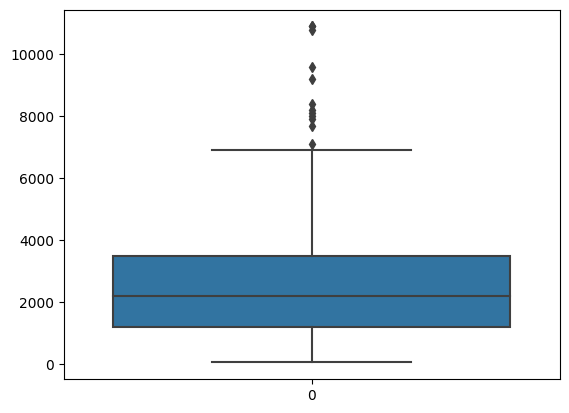

In [161]:
sns.boxplot(data_after_processing.distance_from_center)

We can see that there are outliers in the boxplot- hotels there are very far from the center of the city.

In [162]:
mycols = ["distance_from_center"]
all_outlier_rows = []
for col in mycols:        
        Q1 = np.percentile(data_after_processing[col], 25)
        Q3 = np.percentile(data_after_processing[col], 75)
        IQR = Q3 - Q1
        IQR_range = 1.5 * IQR
        col_outlier = data_after_processing[(data_after_processing[col] < Q1 - IQR_range) | 
                              (data_after_processing[col] > Q3 + IQR_range )].index
        all_outlier_rows.extend(col_outlier)
len(set(all_outlier_rows))

12

In [163]:
data_after_processing = data_after_processing.drop(index=all_outlier_rows)

Now we can save the data after cleaning.

We want to add a column that sums the number of facilities and services available in the hotel.

In [190]:
cols = ['swimmingpool', 'breakfast',
       'breakfast_and_dinner', 'free_cancellation', 'air_conditioning',
       'Heating', 'wifi', 'view', 'closet', 'Soundproofing', 'TV',
       'coffee_machine', 'bathroom', 'Lift', 'safe', 'Pets',
       '24_hour_front_desk', 'Bar', 'room_service', 'Fitness centre', 'spa',
       'electric_kettle', 'Minibar', 'tea_coffee_maker', 'Restaurant',
       'garage', 'airport_shuttle', 'non_smoking_rooms', 'security', 'Towels',
       'facilities_for_disabled_guests', 'Hairdryer', 'Iron',
       'car_charging_station']
data_after_processing['sum_facilities'] = data_after_processing[cols].sum(axis=1)

In [192]:
file_name = "./data/hotels_after_cleaning"
data_after_processing.to_csv(file_name, index=False)

# **EDA & Visualization**

We want to see what parameters affect the star rating the most. For that we can use a Heatmap.

In [193]:
file_name = "./data/hotels_after_cleaning"
final_data = pd.read_csv(file_name)

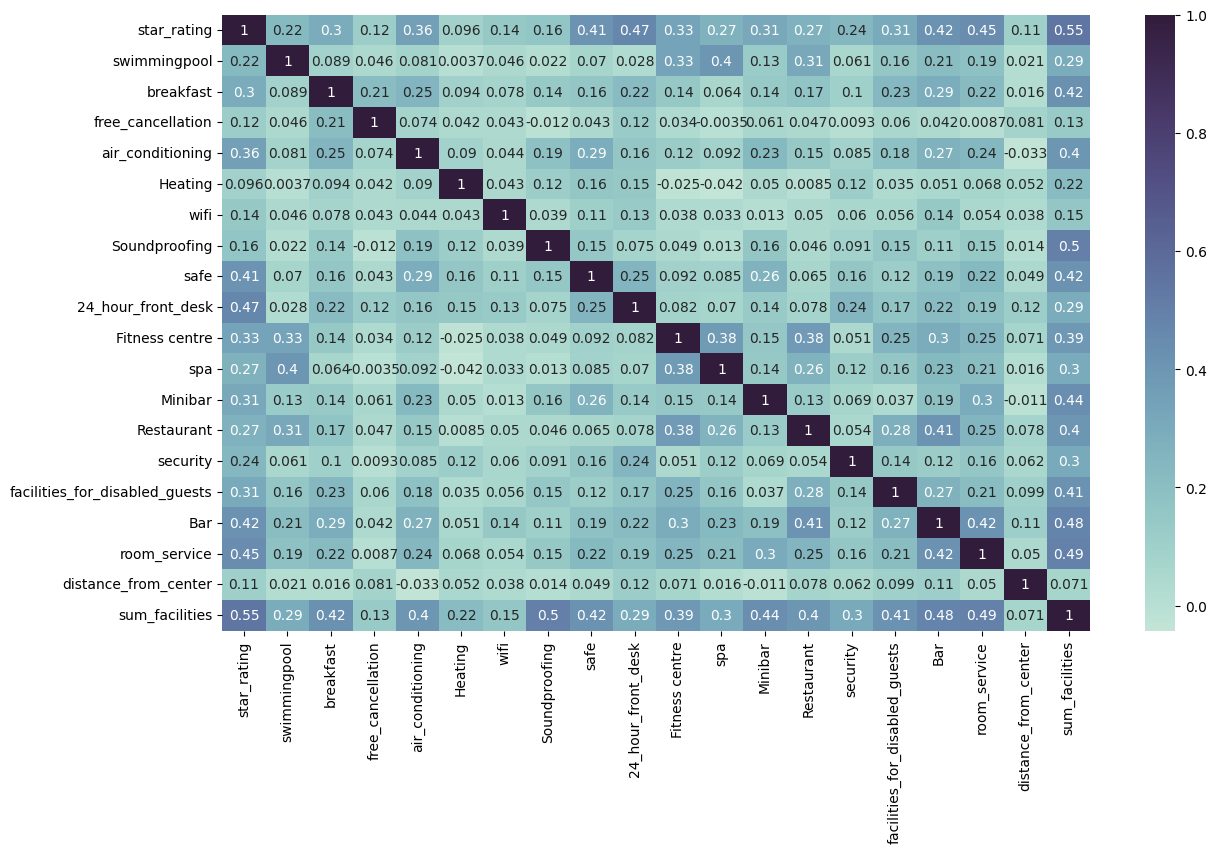

In [195]:
plt.figure(figsize=(14, 8))
cols = ['star_rating', 'swimmingpool', 'breakfast', 'free_cancellation',
       'air_conditioning', 'Heating', 'wifi', 'Soundproofing', 'safe',
       '24_hour_front_desk', 'Fitness centre',
       'spa', 'Minibar', 'Restaurant', 'security',
       'facilities_for_disabled_guests','Bar', 'room_service', 'distance_from_center', 'sum_facilities']
colormap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
# make a subdataframe for the heatmap
df1 = pd.DataFrame(final_data, columns = cols)
sns.heatmap(df1.corr(), annot=True, cmap=colormap)
plt.show()

<AxesSubplot: xlabel='star_rating', ylabel='distance_from_center'>

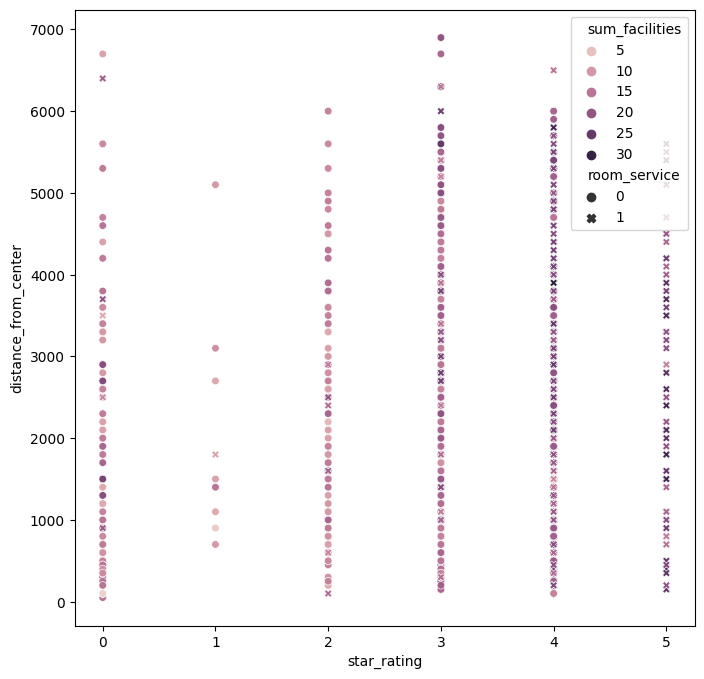

In [202]:
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x = 'star_rating', y = 'distance_from_center', s= 30, hue = 'sum_facilities', style= 'room_service', data=data_after_processing)

We can see in the scatter plot that most of the hotels with 4-5 stars have room service and a large number of facilities and services overall.

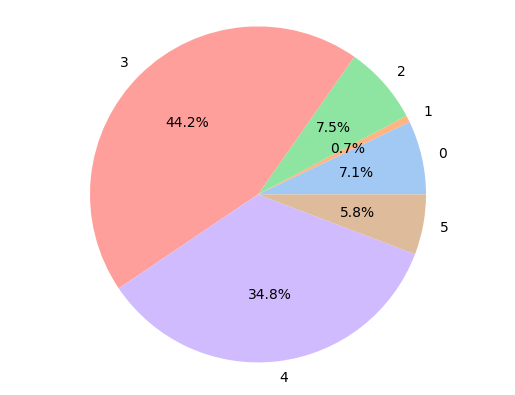

In [203]:
star_ratings = data_after_processing.groupby('star_rating').size()
colormap = sns.color_palette("pastel")
plt.pie(star_ratings, labels=star_ratings.index, autopct='%1.1f%%', colors=colormap)
plt.axis('equal')
plt.show()

We can see that most of the hotels have either 3 or 4 stars.

# **Machine Learning**

Our goal is to predict the star rating of a hotel. We want to classify the hotel to one of 5 groups. We will use Logistic Regression.